In [57]:
import os 
from os.path import join, basename

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import median_abs_deviation

from BCBio import GFF
import scanpy as sc

In [58]:
RAW_DATA_DIR = os.environ["RAW_DATA"]
PROCESSED_DATA_DIR = os.environ["PROCESSED_DATA"]
gff_file = join(RAW_DATA_DIR, "references/bsubtilis/bacillus_subtilis_py79.gff")
input_path = join(PROCESSED_DATA_DIR,  'SRP266243/SRR11940660/STAR_Bsub_ref_gtfconverted_outs/STAR_OUTPUT_Solo.out/Gene/raw/')

In [59]:
def get_protein_id(feature):
    try:
        protein_id = feature.sub_features[0].qualifiers.get("protein_id")
        if protein_id:
            return protein_id[0]
        else:
            return ""
    except:
        return ""
        
def get_product_name(feature):
    try:
        product = feature.sub_features[0].qualifiers.get("product")
        if product:
            return product[0]
        else:
            return ""
    except:
        return ""
def calculate_qc_metrics(data):
    sc.pp.calculate_qc_metrics(
        data, qc_vars=["rRNA", "tRNA"], inplace=True, percent_top=[20], log1p=True
    )
    print(adata)

def plot_qc(data):
    sns.displot(data.obs, x = "total_counts", bins = 100)
    sc.pl.violin(data, ['n_genes_by_counts'], jitter=0.4)
    sc.pl.violin(data, ['pct_counts_rRNA', 'pct_counts_tRNA'], jitter=0.4)
    sc.pl.scatter(data, "total_counts", "n_genes_by_counts", color="pct_counts_rRNA")
    sc.pl.scatter(data, "total_counts", "n_genes_by_counts", color="pct_counts_tRNA")

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [60]:
protein_ids = []
feature_ids = []
feature_types = []
product_names = []
in_handle = open(gff_file)
for rec in GFF.parse(in_handle):
    for feature in rec.features:
        if feature.type == "gene":
            protein_ids.append(get_protein_id(feature))
            product_names.append(get_product_name(feature))
            feature_ids.append(feature.qualifiers["ID"][0])
            feature_types.append(feature.qualifiers["gene_biotype"][0])
in_handle.close()

ids_map = {id_: f"{id_}_{t}" for id_, t in dict(zip(feature_ids, feature_types)).items()}
feature_types_map = dict(zip(feature_ids, feature_types))
protein_ids_map = dict(zip(feature_ids, protein_ids))
product_names_map = dict(zip(feature_ids, product_names))


In [63]:
### Read data
adata = sc.read_10x_mtx(
    input_path,    
    var_names="gene_ids",
    cache=True
)
print(adata)

AnnData object with n_obs × n_vars = 884736 × 4256
    var: 'gene_symbols', 'feature_types'


In [75]:
adata.var["gene_type"] = adata.var_names.map(feature_types_map)
adata = adata[:, ~adata.var["gene_type"].isna()].copy()
adata.var["protein_id"] = adata.var_names.map(protein_ids_map)
adata.var["product_names"] = adata.var_names.map(product_names_map)

adata.var["rRNA"] = adata.var["gene_type"].str.contains(("rRNA"))
adata.var["tRNA"] = adata.var["gene_type"].str.contains(("tRNA"))

In [65]:
calculate_qc_metrics(adata)

AnnData object with n_obs × n_vars = 884736 × 4253
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'total_counts_tRNA', 'log1p_total_counts_tRNA', 'pct_counts_tRNA'
    var: 'gene_symbols', 'feature_types', 'gene_type', 'protein_id', 'rRNA', 'tRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


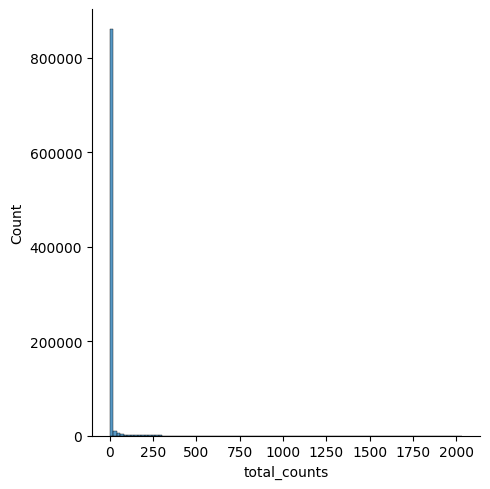

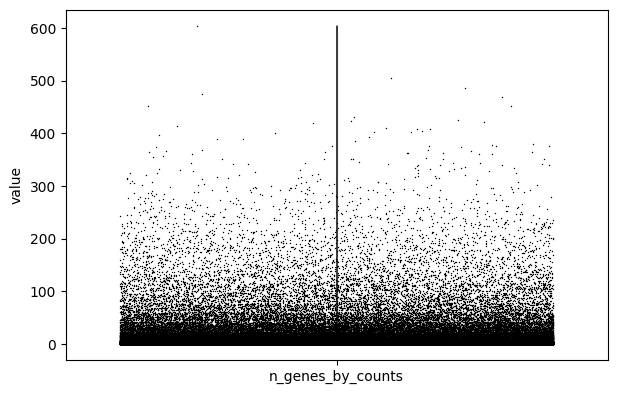

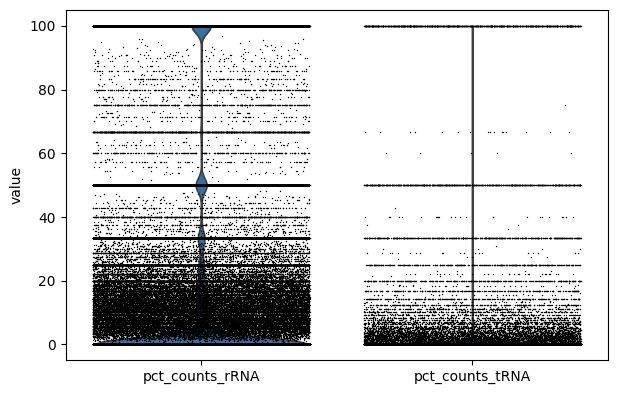

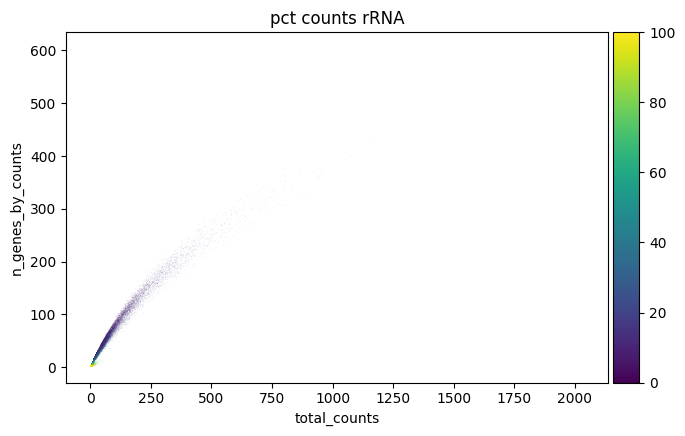

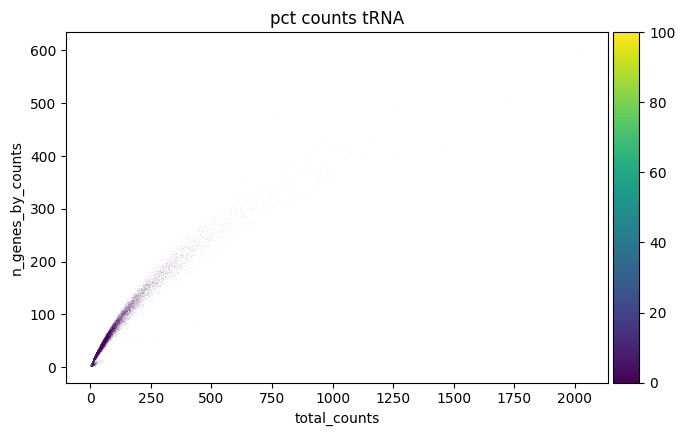

In [66]:
plot_qc(adata)

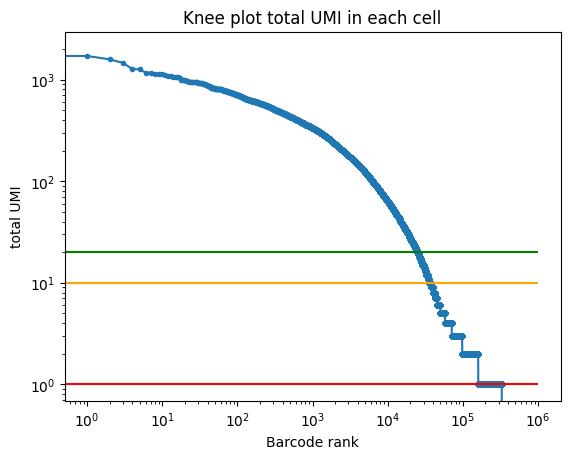

In [22]:
plt.plot(sorted(adata.obs["total_counts"], reverse=True), marker = ".")
plt.xlabel("Barcode rank")
plt.ylabel("total UMI")
plt.title("Knee plot total UMI in each cell")
plt.hlines(1, 0, 1e6, color = "red", label = "1 UMI")
plt.hlines(10, 0, 1e6, color = "orange", label = "10 UMI")
plt.hlines(20, 0, 1e6, color = "green", label = "100 UMI")
plt.xscale("log")
plt.yscale("log")


In [76]:
print(f"Total number of cells: {adata.n_obs}")
adata_filter = adata.copy()
sc.pp.filter_cells(adata_filter, min_counts=20)
print(f"Total number of cells: {adata_filter.n_obs}")

Total number of cells: 884736
Total number of cells: 25133


In [77]:
adata_filter.obs["outlier"] = (
    is_outlier(adata_filter, "log1p_total_counts", 5)
    | is_outlier(adata_filter, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata_filter, "pct_counts_in_top_20_genes", 5)
    | is_outlier(adata_filter, "pct_counts_rRNA", 5)
)
print(adata_filter.obs.outlier.value_counts())
adata_filter = adata_filter[~adata_filter.obs["outlier"]]
adata_filter = adata_filter[adata_filter.obs["pct_counts_tRNA"]<10]

outlier
False    24761
True       372
Name: count, dtype: int64


In [26]:
calculate_qc_metrics(adata_filter)

AnnData object with n_obs × n_vars = 884736 × 4253
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'total_counts_tRNA', 'log1p_total_counts_tRNA', 'pct_counts_tRNA'
    var: 'gene_symbols', 'feature_types', 'gene_type', 'protein_id', 'rRNA', 'tRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_qc.py:145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


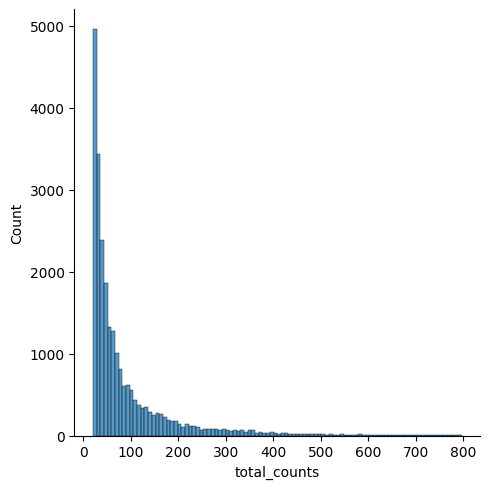

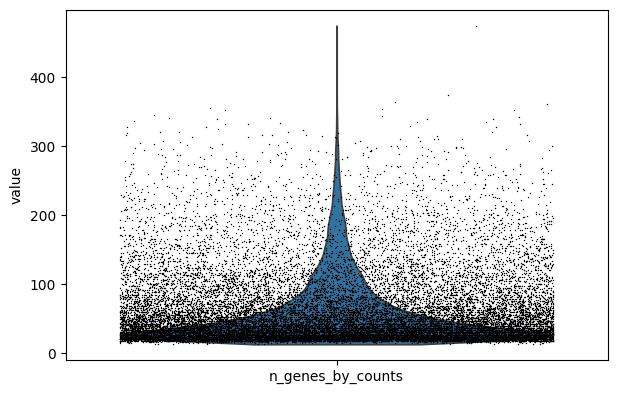

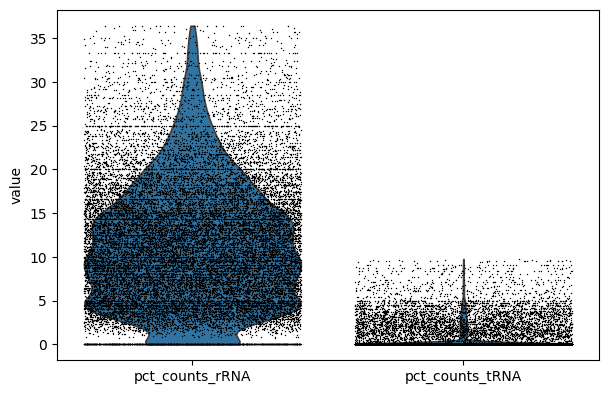

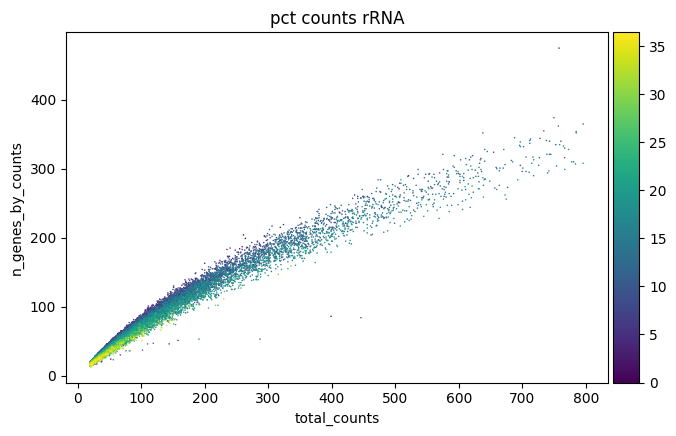

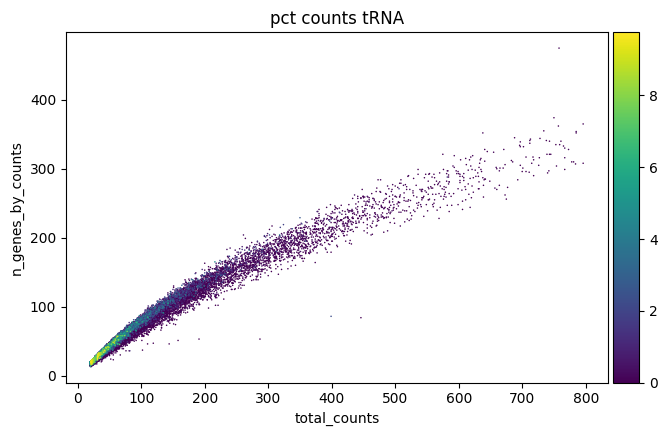

In [27]:
plot_qc(adata_filter)

In [79]:
adata_filter.X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(24645, 4253), dtype=float32)

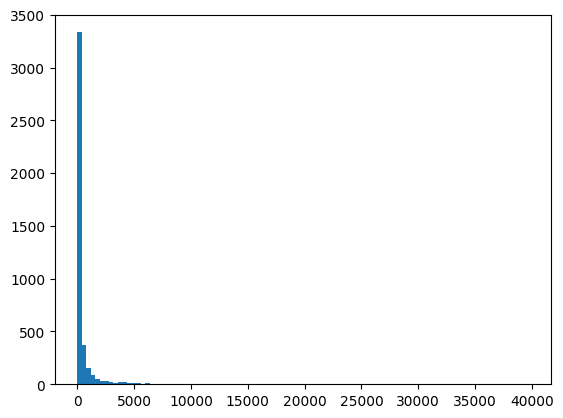

In [82]:
plt.hist(adata_filter.var.n_cells_by_counts, bins = 100 )
plt.show()

In [71]:
adata_filter.X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(24645, 4253), dtype=float32)

In [50]:
adata_norm = adata_filter.copy()
sc.pp.normalize_total(adata_norm, target_sum=10_000, inplace=True)
sc.pp.log1p(adata_norm)

In [51]:
adata_filter.X.toarray().sum(axis = 1)

array([34., 35., 45., ..., 25., 23., 31.], shape=(24645,), dtype=float32)

In [56]:
adata_norm.X.toarray().sum(axis = 1)

array([173.10048, 177.48814, 219.09146, ..., 149.84903, 134.38916,
       174.07504], shape=(24645,), dtype=float32)

AnnData object with n_obs × n_vars = 884736 × 4253
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'total_counts_tRNA', 'log1p_total_counts_tRNA', 'pct_counts_tRNA'
    var: 'gene_symbols', 'feature_types', 'gene_type', 'protein_id', 'rRNA', 'tRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


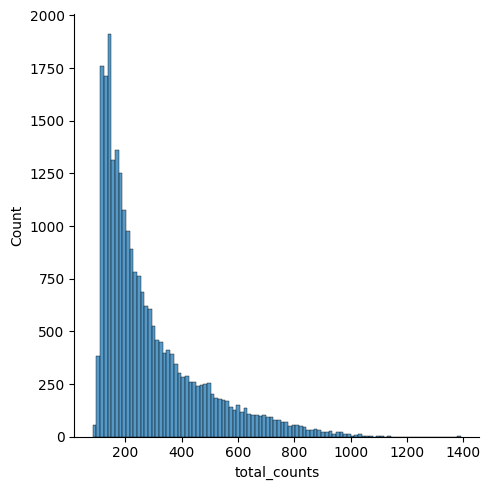

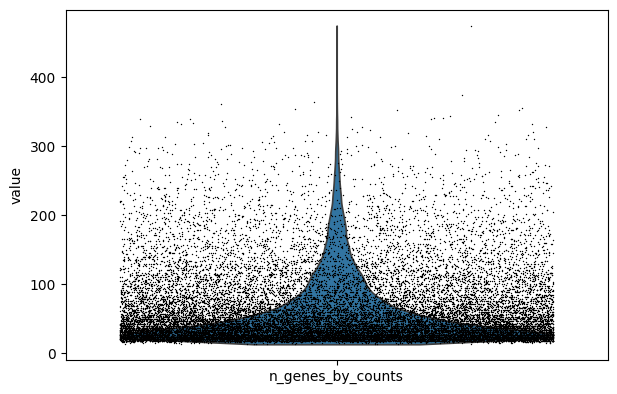

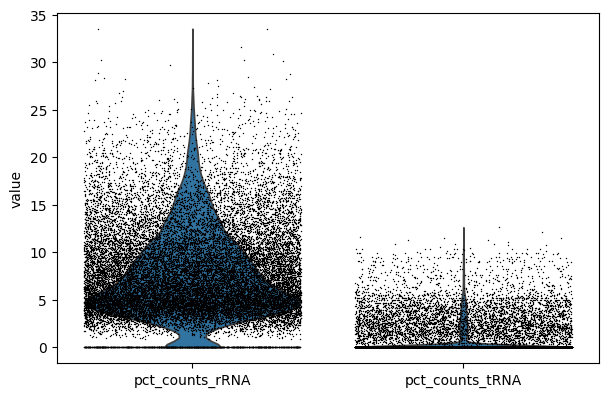

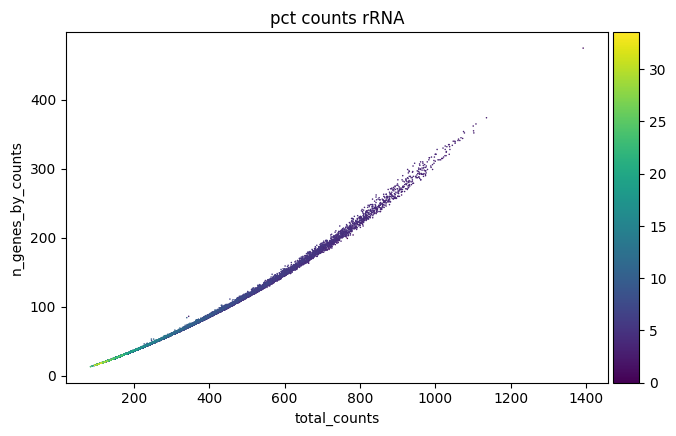

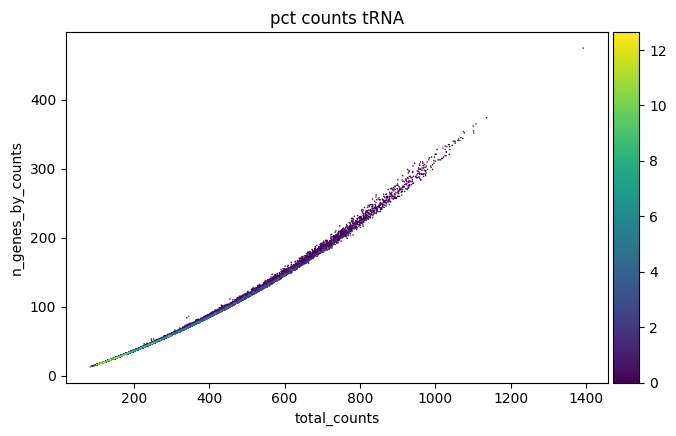

In [55]:
calculate_qc_metrics(adata_norm)
plot_qc(adata_norm)